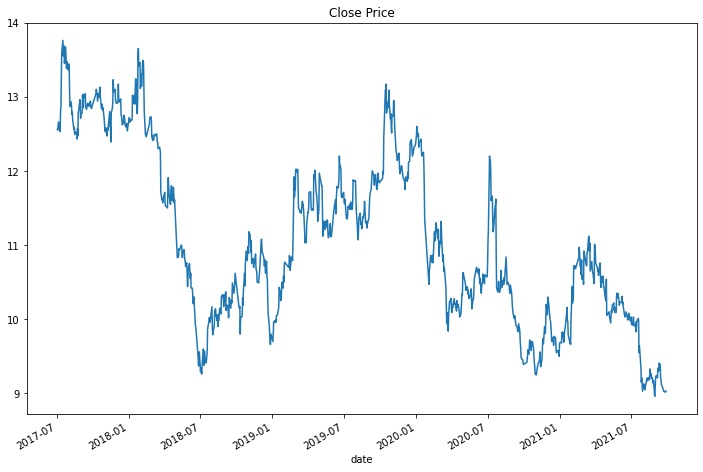

In [1]:
import pandas as pd
import numpy as np
import datetime

from statsmodels.tsa.stattools import acf, pacf
import pandas as pd
import numpy as np
import datetime
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")

if __name__ == '__main__':
    stock_df = pd.read_csv('D600000.csv')
    stock_df['date'] = pd.to_datetime(stock_df['date'])
    stock_df.set_index('date', inplace=True)
    stock_df = stock_df['close']
    plt.figure(figsize=(12,8))
    stock_df.plot()
    plt.title('Close Price')

In [2]:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(stock_df)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                   -1.825309
p-value                           0.367971
#Lags Used                        4.000000
Number of Observations Used    1030.000000
Critical Value (1%)              -3.436715
Critical Value (5%)              -2.864350
Critical Value (10%)             -2.568266
dtype: float64


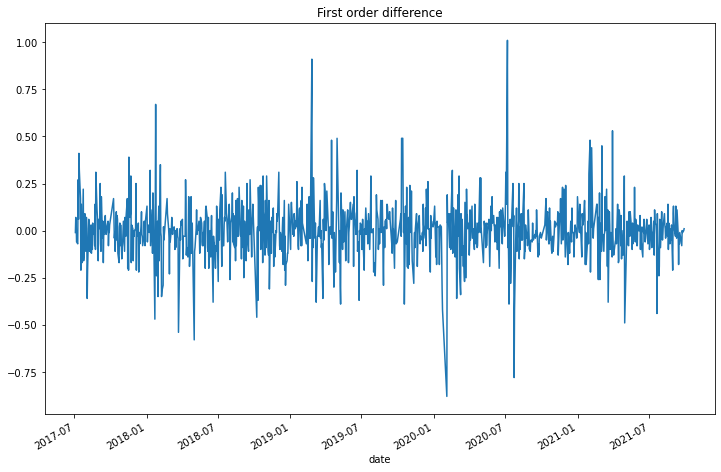

In [3]:
    stock_diff = stock_df - stock_df.shift(1)
    stock_diff.dropna(inplace=True)
    plt.figure(figsize=(12,8))
    stock_diff.plot()
    plt.title('First order difference')
    plt.show()

In [4]:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(stock_diff)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                -1.694009e+01
p-value                        9.632060e-30
#Lags Used                     3.000000e+00
Number of Observations Used    1.030000e+03
Critical Value (1%)           -3.436715e+00
Critical Value (5%)           -2.864350e+00
Critical Value (10%)          -2.568266e+00
dtype: float64


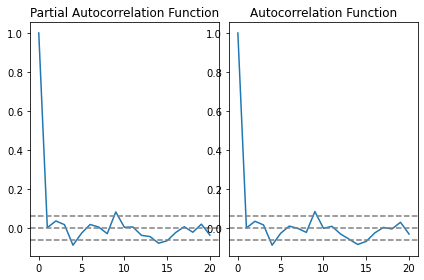

In [5]:
    lag_pacf = pacf(stock_diff, nlags=20)
    lag_acf = acf(stock_diff, nlags=20)

    # Plot PACF:
    plt.subplot(121)
    plt.plot(lag_pacf)
    plt.axhline(y=0, linestyle='--', color='gray')
    plt.axhline(y=-1.96 / np.sqrt(len(stock_diff)), linestyle='--', color='gray')
    plt.axhline(y=1.96 / np.sqrt(len(stock_diff)), linestyle='--', color='gray')
    plt.title('Partial Autocorrelation Function')
    plt.tight_layout()

    # Plot ACF:
    plt.subplot(122)
    plt.plot(lag_acf)
    plt.axhline(y=0, linestyle='--', color='gray')
    plt.axhline(y=-1.96 / np.sqrt(len(stock_diff)), linestyle='--', color='gray')
    plt.axhline(y=1.96 / np.sqrt(len(stock_diff)), linestyle='--', color='gray')
    plt.title('Autocorrelation Function')

    plt.show()

In [6]:
    d = [1]
    p = [0, 1, 2, 3, 4, 5, 6]
    q = [0, 1, 2, 3, 4, 5, 6]
    pdq = list(itertools.product(p, d, q))

    result_list = []
    total_combinations = len(pdq)
    run_id = 0

    for param in pdq:

        run_id += 1
        #print("\n>>>>> RUN", run_id, "OF", total_combinations)
        try:
            mod = ARIMA(stock_df, order=param)
            results = mod.fit()
            result_list.append(
                'ARIMA{} - AIC:{}'.format(param, results.aic))
        except:
            continue

    print()
    for res in result_list:
        print(res)



ARIMA(0, 1, 0) - AIC:-1021.1134833059155
ARIMA(0, 1, 1) - AIC:-1019.1167161180729
ARIMA(0, 1, 2) - AIC:-1018.724442080188
ARIMA(0, 1, 3) - AIC:-1017.116121859829
ARIMA(0, 1, 4) - AIC:-1023.4718479430549
ARIMA(0, 1, 5) - AIC:-1021.5826856801818
ARIMA(0, 1, 6) - AIC:-1019.6777112561581
ARIMA(1, 1, 0) - AIC:-1019.1169475346837
ARIMA(1, 1, 1) - AIC:-1017.2554691929822
ARIMA(1, 1, 2) - AIC:-1016.8005653687587
ARIMA(1, 1, 3) - AIC:-1022.4776413550326
ARIMA(1, 1, 4) - AIC:-1021.56362916841
ARIMA(1, 1, 5) - AIC:-1019.6208589396119
ARIMA(1, 1, 6) - AIC:-1017.6817930858315
ARIMA(2, 1, 0) - AIC:-1018.4447652406998
ARIMA(2, 1, 1) - AIC:-1016.4943061120784
ARIMA(2, 1, 2) - AIC:-1023.1970396326942
ARIMA(2, 1, 3) - AIC:-1021.9316452385865
ARIMA(2, 1, 4) - AIC:-1020.3843163721772
ARIMA(2, 1, 5) - AIC:-1018.9009931111664
ARIMA(2, 1, 6) - AIC:-1018.5112893219998
ARIMA(3, 1, 0) - AIC:-1016.7412772562407
ARIMA(3, 1, 1) - AIC:-1021.9210890749405
ARIMA(3, 1, 2) - AIC:-1021.2049178222787
ARIMA(3, 1, 3) - AI

In [7]:
    stock_df = stock_df.dropna()
    model = ARIMA(stock_df, order=(6, 1, 5))
    result = model.fit()
    print(result.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.close   No. Observations:                 1034
Model:                 ARIMA(6, 1, 5)   Log Likelihood                 529.333
Method:                       css-mle   S.D. of innovations              0.145
Date:                Fri, 15 Oct 2021   AIC                          -1032.667
Time:                        00:04:37   BIC                           -968.431
Sample:                             1   HQIC                         -1008.293
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0034      0.005     -0.745      0.456      -0.012       0.006
ar.L1.D.close     0.4691      0.102      4.595      0.000       0.269       0.669
ar.L2.D.close     0.0528      0.233     

In [8]:
    model_ex = ARIMA(stock_df, order=(1, 1, 1))
    result_ex = model_ex.fit()
    print(result_ex.summary())

    ts = result_ex.predict()
    df_fill = stock_df[ts.index]
    print('RMSE:{}'.format(np.sqrt(sum((ts - df_fill) ** 2) / ts.size)))

                             ARIMA Model Results                              
Dep. Variable:                D.close   No. Observations:                 1034
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 512.628
Method:                       css-mle   S.D. of innovations              0.147
Date:                Fri, 15 Oct 2021   AIC                          -1017.255
Time:                        00:04:38   BIC                           -997.491
Sample:                             1   HQIC                         -1009.756
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0034      0.005     -0.732      0.464      -0.013       0.006
ar.L1.D.close     0.3967      0.644      0.616      0.538      -0.866       1.659
ma.L1.D.close    -0.3859      0.647     

之后20天预测
2021-09-28    9.022063
2021-09-29    9.017217
2021-09-30    9.024508
2021-10-01    9.038734
2021-10-04    9.029224
2021-10-05    9.024944
2021-10-06    9.020211
2021-10-07    9.013273
2021-10-08    8.995140
2021-10-11    8.989429
2021-10-12    8.985117
2021-10-13    8.984396
2021-10-14    8.982311
2021-10-15    8.989616
2021-10-18    8.991879
2021-10-19    8.992546
2021-10-20    8.987573
2021-10-21    8.983714
2021-10-22    8.972865
2021-10-25    8.963362
2021-10-26    8.953814
2021-10-27    8.949835
2021-10-28    8.945952
2021-10-29    8.947570
2021-11-01    8.949541
2021-11-02    8.953073
2021-11-03    8.952382
2021-11-04    8.950834
2021-11-05    8.944581
2021-11-08    8.937110
Freq: B, dtype: float64


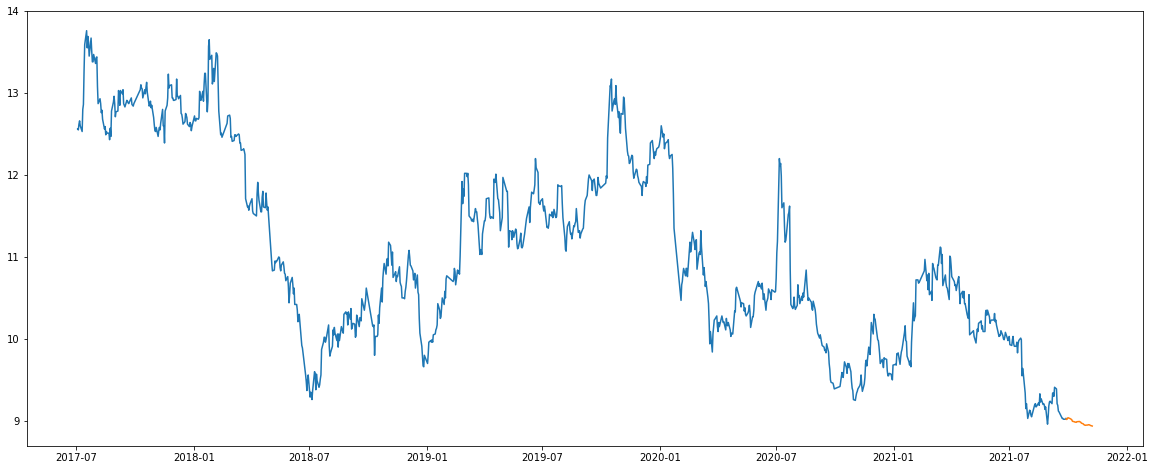

In [9]:
    print('之后20天预测')
    pred = result.forecast(30)
    pred = pd.Series(pred[0], index=pd.period_range('20210928', '20211106', freq='B'))
    print(pred)
    plt.figure(figsize=(20, 8))
    plt.plot(stock_df)
    plt.plot(pred)
    plt.show()

In [10]:
    ts = result.predict()
    df_fill = stock_df[ts.index]
    print('RMSE:{}'.format(np.sqrt(sum((ts - df_fill) ** 2) / ts.size)))

RMSE:11.123253932936365


In [11]:
    # 残差校验
    '''
    主要针对残差进行正态性检验和自相关性检验。
    残差满足正态性，主要是为了残差集中于某一个数值，如果该值与0很接近，则它实际服从均值为0的正态分布，即它是一个白噪声。
    白噪声是指功率谱密度在整个频域内均匀分布的噪声。白噪声或白杂讯，是一种功率频谱密度为常数的随机信号或随机过程。换句话说，此信号在各个频段上的功率是一样的，由于白光是由各种频率（颜色）的单色光混合而成，因而此信号的这种具有平坦功率谱的性质被称作是“白色的”，此信号也因此被称作白噪声。
    残差满足非自相关性，主要是为了在残差中不再包括AR或者MA过程产生的序列。

    为什么残差要是白噪声？
    得到白噪声序列，就说明时间序列中有用的信息已经被提取完毕了，剩下的全是随机扰动，是无法预测和使用的，
    残差序列如果通过了白噪声检验，则建模就可以终止了，因为没有信息可以继续提取。如果残差不是白噪声，就说明残差中还有有用的信息，需要修改模型或者进一步提取。

    '''
    resid = result.resid  # 赋值
    # Durbin-Watson）检验
    '''
    当DW值显著的接近于O或４时，则存在自相关性，而接近于２时，则不存在（一阶）自相关性。这样只要知道ＤＷ统计量的概率分布，在给定的显著水平下，根据临界值的位置就可以对原假设Ｈ０进行检验
    '''
    print(sm.stats.durbin_watson(result.resid.values))
    # 白噪声检验
    '''
    时间序列中一个最基本的模型就是高斯白噪声序列。而对于ARIMA模型，
    其残差被假定为高斯白噪声序列，所以当我们用ARIMA模型去拟合数据时，
    拟合后我们要对残差的估计序列进行LB检验，判断其是否是高斯白噪声，
    如果不是，那么就说明ARIMA模型也许并不是一个适合样本的模型。
    '''
    r, q, p = sm.tsa.acf(resid.values.squeeze(), qstat=True)
    data = np.c_[range(1, 41), r[1:], q, p]
    table = pd.DataFrame(data, columns=['lag', "AC", "Q", "Prob(>Q)"])
    print(table.set_index('lag'))


2.0006531796854823
            AC          Q  Prob(>Q)
lag                                
1.0  -0.000329   0.000112  0.991557
2.0   0.013178   0.180382  0.913756
3.0   0.008975   0.264072  0.966638
4.0   0.011653   0.405287  0.982042
5.0  -0.021535   0.888093  0.971078
6.0  -0.008394   0.961511  0.987029
7.0  -0.013418   1.149303  0.992048
8.0  -0.004736   1.172720  0.996904
9.0   0.024527   1.801448  0.994232
10.0 -0.026613   2.542369  0.990244
11.0  0.000392   2.542530  0.995498
12.0 -0.009508   2.637296  0.997608
13.0 -0.058084   6.177005  0.939473
14.0 -0.049807   8.782322  0.844737
15.0 -0.043300  10.753328  0.769877
16.0 -0.002056  10.757777  0.824184
17.0 -0.004390  10.778080  0.867865
18.0 -0.007059  10.830617  0.901406
19.0  0.001294  10.832384  0.929348
20.0 -0.043751  12.854586  0.883536
21.0  0.010176  12.964099  0.909876
22.0 -0.012510  13.129752  0.929479
23.0 -0.045850  15.357218  0.881375
24.0  0.031533  16.411852  0.872640
25.0  0.053625  19.464786  0.774307
26.0 -0.0

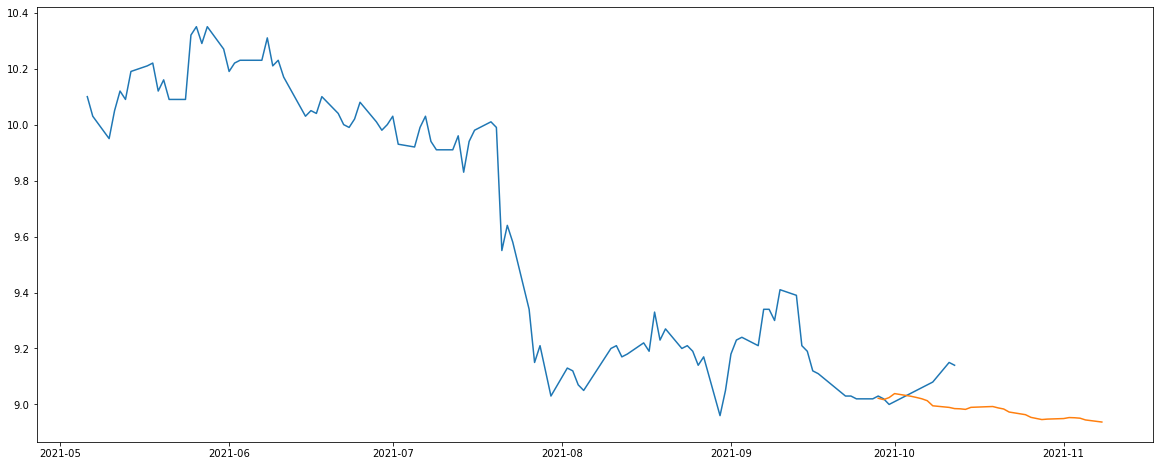

In [12]:
    stock_df1 = pd.read_csv('600000.SS.csv')
    # 格式化时间
    stock_df1['Date'] = pd.to_datetime(stock_df1['Date'])
    stock_df1.set_index('Date', inplace=True)
    # 提取 close
    stock_df1 = stock_df1['Close']
    plt.figure(figsize=(20, 8))
    stock_tmp =stock_df1['20210501':'20211012']
    plt.plot(stock_tmp)
    plt.plot(pred)
    plt.show()